# Creating the synthetic spectra.

## 0 Packages and data

In [62]:
cd /content

/content


In [63]:
!git clone https://github.com/folsomcp/specpolFlow

fatal: destination path 'specpolFlow' already exists and is not an empty directory.


In [64]:
import specpolFlow as pol
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import os
import copy

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
cd /content/drive/Shareddrives/BeStarsMiMeS/

/content/drive/Shareddrives/BeStarsMiMeS


## 1. Calculating the disk integrated, rotationally broadened spectra

### 1.0 Setting up the location in the Shared Drive and permissions

(This only need need to be done once)

moving to the directory on the Shared Drive with the Synth executables

In [67]:
cd /content/drive/Shareddrives/BeStarsMiMeS/Synth-codes

/content/drive/Shareddrives/BeStarsMiMeS/Synth-codes


In [68]:
# double checking that I am at the right place.
!pwd

/content/drive/Shareddrives/BeStarsMiMeS/Synth-codes


In [69]:
# Need to change the permissions on the executable
# So that it will run.
! chmod 755 s3div.Linux

### 1.1 Demo with a single observation

A succesfull calculation should output:

```
 Integration done
```
and create a new file in the `Synth-diskint-spectra` folder on the Shared Google Drive

There might be this error as well
```
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (wrong ELF class: ELFCLASS64): ignored.
```
but it does not seem to affect the calculation.

In [70]:
star = 'hd6226'
ModelCode='T15000G40'
vsini = 120.0
vmac = 2.0
res = 65000


file_mout = '../Synth-local-spectra/{}.mout'.format(ModelCode)
file_int  = '../Synth-diskint-spectra/{}.dsk'.format(star)

command = './s3div.Linux {} {} {} {} 167000 {}'.format(file_mout, file_int, vsini, vmac, res)
#print(command)
stream = os.popen(command)
output = stream.readlines()
output


[' Integration done\n']

Going back to the main directory in the Shared Google Drive

In [71]:
cd /content/drive/Shareddrives/BeStarsMiMeS

/content/drive/Shareddrives/BeStarsMiMeS


### 1.1 Demo with a single observation

> **TODO**: make a loop that makes the calculation above for each star, using the information in the 00-Information spreadsheets. 

## 2. Adding radial velocity shift and noise. 

Gregg originally had an IDL code to do this, using a list of SNR (from the headers of the observations?)

But as we do have the original spectra handy, I propose a maybe simpler python procedure. 

1. Read in the original spectrum for an observation
2. Read in the rotationally broadened model spectrum that has been convolved with the instrument resolution by `s3div` already. 
3. Shift the model by the appropriate radial velocity for that observation.
4. Split the observation into its orders (so this is assuming that the spectrum's orders have not been merged. If using a code that merges the order, then there should be an option to do this procedure in one swoop, instead of order by order. For each order, do the folloowing:
  - a. Interpolate the shifted model spectrum to the wavelength grid of the observed spectrum
  - b. Add some random noise to the interpolated model, using the observed error column as the sigma of the normal distribution. 
  - c. Copy over all of the other columns from the data -- this way there is no need to stitch together the LSD profiles after the fact. 
5. Save the resulting spectrum in .s format. 

Functions that will be used below (move this to a module on the github, maybe? split and splice could go into the iolsd.observation class, once there is a check added in case there are no spectral orders present -- i.e. for already mearged observations)

In [72]:
def read_disk(file):
  '''
  Read a synthetic spectrum from a s3div output

  :param file: The filename
  :rtype: wave, flux -- the wavelength in nm, and the normalized flux. 
  '''
  with open(file) as f:
    lines = f.readlines()
  # number of atomic lines in the header of the file
  natomic = int(lines[0].split(sep='-')[0])
  nwave=int(lines[natomic+1].split()[0])
  data = np.genfromtxt(lines[natomic+2:natomic+1+nwave])
  return(data[:,0]/10.0, data[:,1])

def split_order(data):
  '''
  Split an observation object into a list of observation objects with one order per item
  '''
  # one order is where the wavelength backtracks. 
  ind = np.where((data.wl[1:]-data.wl[0:-1]) < 0)[0]
  norder = ind.size+1
  ind = np.append(-1,ind)
  ind = np.append(ind,data.wl.size)
  print('{} orders'.format(norder))

  list_order=[]
  for i in range(0,norder):
    list_order.append(data[ind[i]+1:ind[i+1]])
 
  return(list_order)
  
def splice_order(list_order):
  '''
  Concatenate a list of observation objects (usually split into a list of orders by split_order function). Note: it does not merge the orders overlaps.
  '''
  wl = np.array([])
  specI = np.array([])
  specV = np.array([])
  specN1 = np.array([])
  specN2 = np.array([])
  specSig = np.array([])
  for item in list_order:
    wl=np.append(wl,item.wl)
    specI=np.append(specI,item.specI)
    specV=np.append(specV,item.specV)
    specN1=np.append(specN1,item.specN1)
    specN2=np.append(specN2,item.specN2)
    specSig=np.append(specSig, item.specSig)
  return(pol.iolsd.observation(wl, specI, specV, specN1, specN2, specSig, header=list_order[0].header))

def rshift(wave, radvel):
  '''
  Shift a spectrum in terms of radial velocity. The wavelength array and the velocity arrays must be defied as astropy units quantities.
  The new wavelength array is returned in the same units as the initial wavelength array. 
  '''
  return( (wave + wave*radvel/const.c).to(wave.unit).value )


### 2.1 Demo with a single observation

In [73]:
# Making sure we are in the right directory
! pwd

/content/drive/Shareddrives/BeStarsMiMeS


In [74]:
star = 'hd6226'
obs = '1'
vradCorrected = -70.0

> **TODO** Need to check whether this will work with normalized HARPS spectra (seem to remember something funny in the sorting of the wavelength arrays...)
(star #3 on the list has a HARPS spectrum, I think)

In [75]:
# reading the observed spectrum
file_obs = 'NormalizedSpectra/{}_{}.s'.format(star, obs)
data_obs = pol.iolsd.read_spectrum(file_obs)
# splitting the observed spectrum by order
list_order = split_order(data_obs)

# reading the model spectrum
file_mod = 'Synth-diskint-spectra/{}.dsk'.format(star)
mod_wave, mod_flux = read_disk(file_mod)

# shifting the model spectrum for its radial velocity
# (note the rshift function asks for numpy unit quantities)
mod_wave_shift = rshift(mod_wave*u.nm, vradCorrected*u.km/u.s)

for order in list_order:

  # interpolate the shifted model onto the order grid
  mod_flux_interp = np.interp(order.wl, mod_wave_shift, mod_flux)

  # drawing n random elements with a mean of zero and a stdev of 1.0
  # scaling to a sigma corresponding to the error bar
  noise = np.random.standard_normal(order.wl.size)*order.specSig
  mod_flux_interp = mod_flux_interp + noise
  # replacing the flux array in the order
  order.specI = copy.deepcopy(mod_flux_interp)

# putting the orders back together
new = splice_order(list_order)

### writting back the file in the proper folder. 
## need to look for a write function for .s, maybe in Colin's 
## normalization code?

new.write_s('Synth-hybrid-spectra/{}_{}_noise.s'.format(star,obs))

37 orders


Quick graph to check the result -- the graph is not needed for the loop below. The comparison between model and data is done in the 02-NormalizedSpectra notebook. 

(0.5, 1.1)

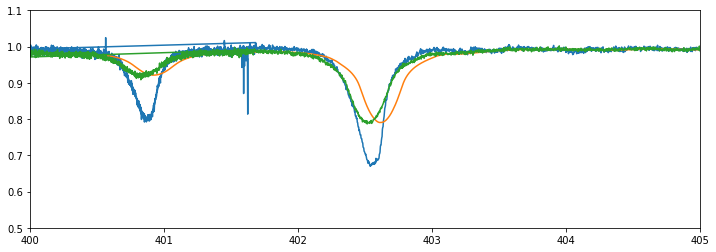

In [78]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(data_obs.wl, data_obs.specI)
ax.plot(mod_wave, mod_flux)
ax.plot(new.wl, new.specI)
ax.set_xlim(400,405)
ax.set_ylim(0.5,1.1)

### 2.2 Loop over all the observations

>**TODO**: make a loop over all of the observations to make the calculations above for each observation, using the information from the tables in 00-Information Google spreadsheet.